# Multilevel Quantum Circuit Partitioning

This notebook explores the multilevel framework in some more depth and briefly comparese the different coarsening routines. This follows on from the "walkthrough" notebook.

In [5]:
from disqco.circuits.cp_fraction import cp_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions,calculate_full_cost
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from disqco.circuits.QAOA import QAOA_random
import numpy as np
import time
from disqco.graphs.quantum_network import QuantumNetwork

num_qubits = 16
num_partitions = 4
qpu_size = int(num_qubits / num_partitions) + 1
qpu_sizes = [qpu_size] * num_partitions

network = QuantumNetwork(qpu_sizes)


circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5)

circuit = transpile(circuit, basis_gates = ['cp', 'u'])
depth = circuit.depth()

graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network, num_qubits, depth, num_partitions)




initial_cost = calculate_full_cost(graph, assignment, num_partitions)


The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


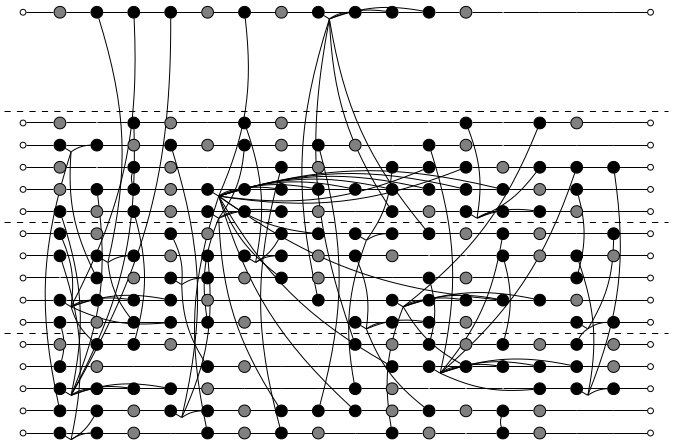

In [6]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
%load_ext jupyter_tikz

draw_graph_tikz(graph, assignment, qpu_sizes)

We first run the normal FM algorithm, with no coarsening, to set a benchmark. We will use the depth of the circuit to calculate the number of passes we will use, for fairness of comparison. We will set a limit on the number of nodes that can be moved per pass.

In [7]:
from disqco.parti.FM.FM_main import run_FM

level_limit = int(np.ceil(np.log2(depth)))

num_passes = (level_limit+1) * 10
move_limit_per_pass = len(graph.nodes)
exploratory = False

final_cost, final_assignment, cost_list = run_FM(
    graph,
    assignment,
    qpu_sizes,
    limit=move_limit_per_pass,
    passes=num_passes,
    log=True,
    add_initial=True,
    stochastic=exploratory
)




Initial cost: 37
All passes complete.
Final cost: 28


In [8]:
from disqco.parti.FM.multilevel_FM import *
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

coarsener = HypergraphCoarsener()

initial_graph_full = graph.copy()

graph_list, mapping_list = coarsener.coarsen_full(initial_graph_full, num_levels = depth)

coarsest_graph = graph_list[-1]



We start by coarsening the graph down to a single time-step, to see how we well can do with static partitioning. The initialisation and termination nodes are included in the figure but are not part of the actual graph.

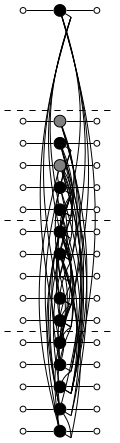

In [9]:
fig = draw_graph_tikz(
    coarsest_graph,
    assignment,
    qpu_sizes
)

display(fig)

In [10]:
final_cost, final_assignment, cost_list = run_FM(coarsest_graph, assignment, qpu_sizes, limit=move_limit_per_pass, max_gain=4*depth, passes=num_passes, log=True)


Initial cost: 37
All passes complete.
Final cost: 23


In some cases, static partitioning can also do very well, but it will often be limited since no state teleportation is possible. We will now look at a multilevel approach using a window-based coarsening routine.

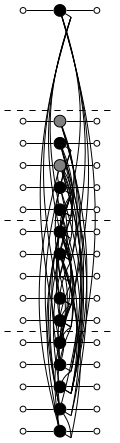

Cost at level 1, 25


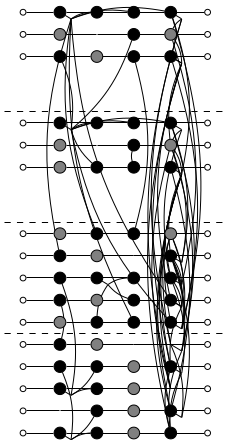

Cost at level 2, 25


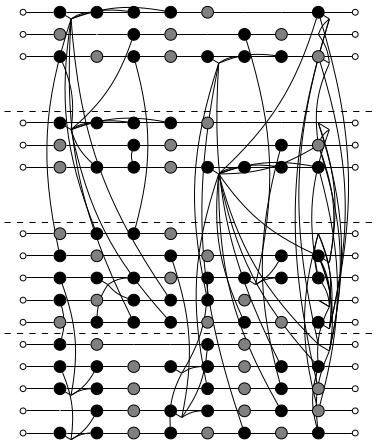

Cost at level 3, 25


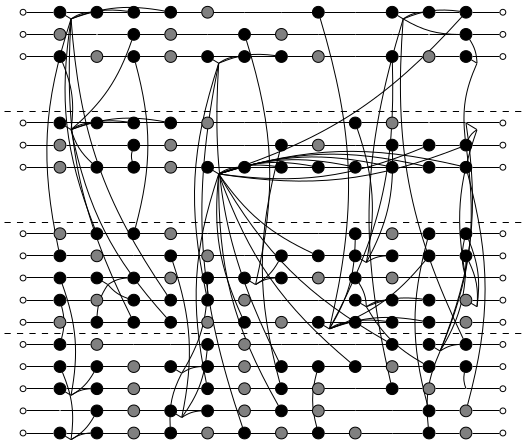

Cost at level 4, 24


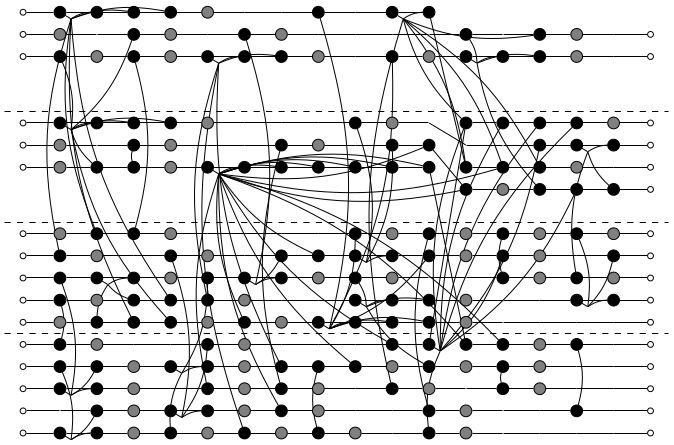

Cost at level 5, 24


In [11]:
initial_graph_window = graph.copy()

graph_list_window, mapping_list_window = coarsener.coarsen_full(initial_graph_window, num_levels = level_limit)

assignment_list_window, cost_list_window, time_list_window = multilevel_FM(graph_list_window, mapping_list_window, assignment, qpu_sizes, limit=move_limit_per_pass,stochastic=exploratory)

i = 0
for g in reversed(graph_list_window):
    fig = draw_graph_tikz(
        g,
        assignment_list_window[i],
        qpu_sizes
    )
    display(fig)
    i += 1
    print(f'Cost at level {i}, {calculate_full_cost(g, assignment_list_window[i], num_partitions)}')

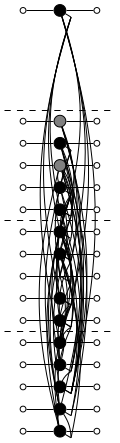

Cost at level 0, 37


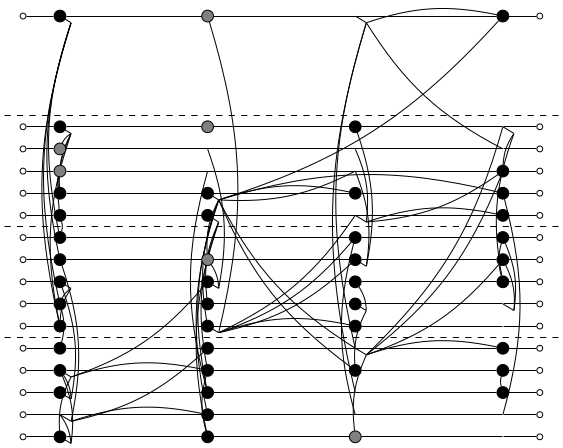

Cost at level 1, 25


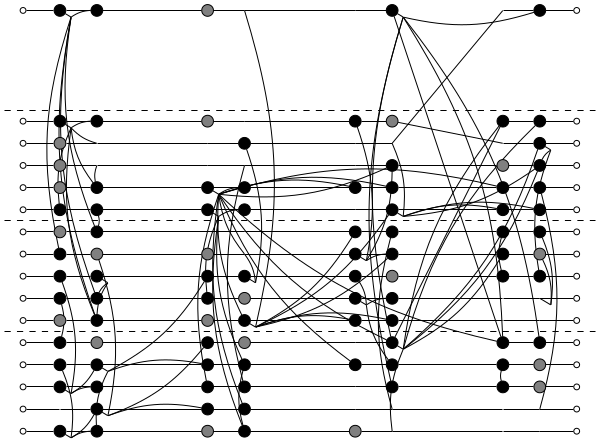

Cost at level 2, 24


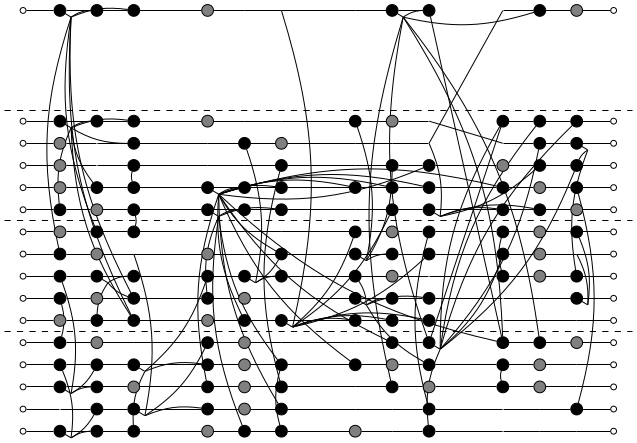

Cost at level 3, 24


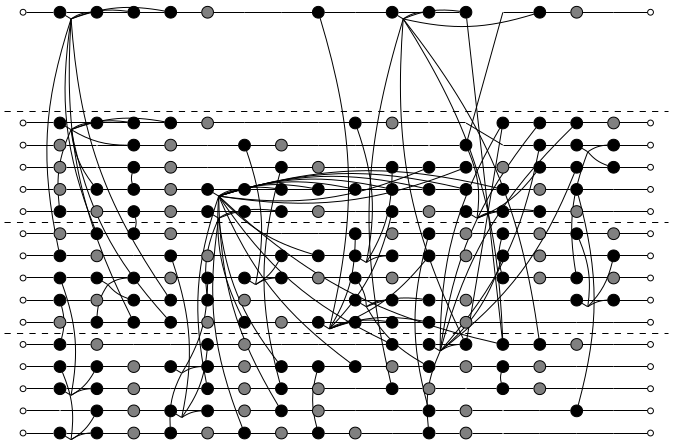

Cost at level 4, 24


In [12]:
initial_graph_blocks = graph.copy()

graph_list_blocks, mapping_list_blocks = coarsener.coarsen_blocks(initial_graph_blocks, num_blocks= None, block_size = level_limit)

assignment_list_blocks, cost_list_blocks, time_list_blocks = multilevel_FM(graph_list_blocks, mapping_list_blocks, assignment, qpu_sizes, limit=move_limit_per_pass,stochastic=exploratory)
i = 0

for g in reversed(graph_list_blocks):
    fig = draw_graph_tikz(
        g,
        assignment_list_blocks[i],
        qpu_sizes
    )
    display(fig)
    print(f'Cost at level {i}, {calculate_full_cost(g, assignment_list_blocks[i], num_partitions)}')
    i += 1

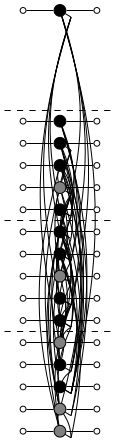

Cost at level 0, 37


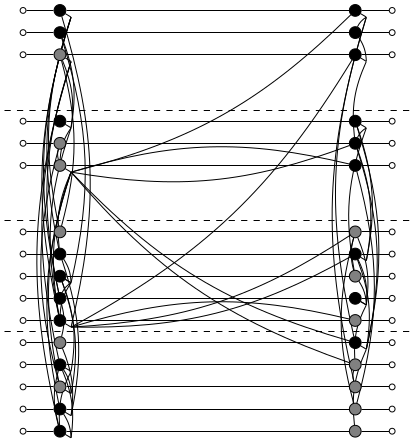

Cost at level 1, 25


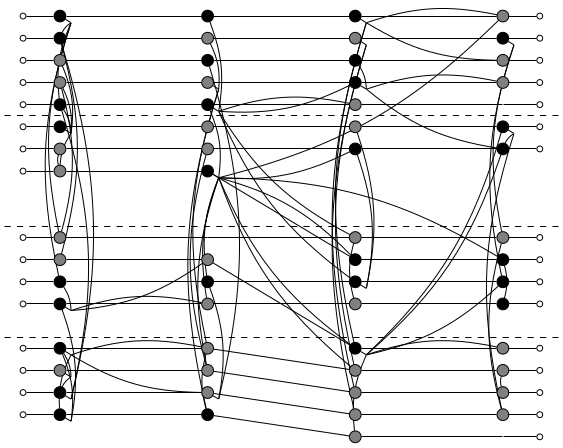

Cost at level 2, 24


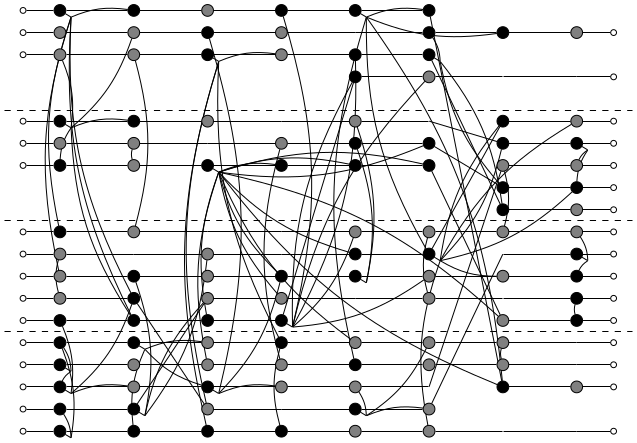

Cost at level 3, 23


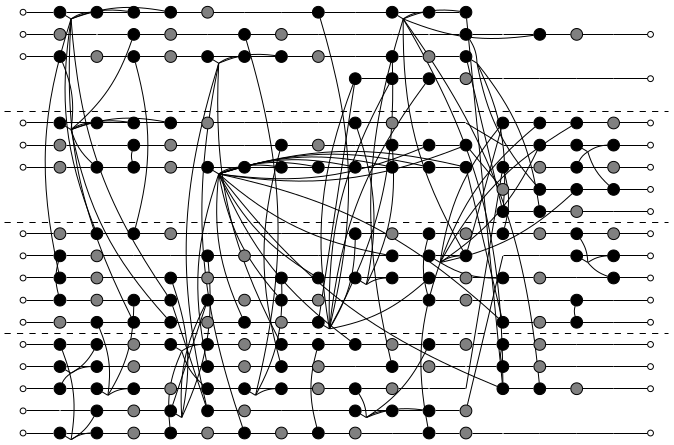

Cost at level 4, 23


In [13]:
initial_graph_recursive = graph.copy()
graph_list_recursive, mapping_list_recursive = coarsener.coarsen_recursive_batches(initial_graph_recursive)

assignment_list_recursive, cost_list_recursive, time_list_recursive = multilevel_FM(graph_list_recursive, mapping_list_recursive, assignment, qpu_sizes, limit=move_limit_per_pass, stochastic=exploratory)
i = 0

for g in reversed(graph_list_recursive):
    fig = draw_graph_tikz(
        g,
        assignment_list_recursive[i],
        qpu_sizes
    )
    display(fig)
    print(f'Cost at level {i}, {calculate_full_cost(g, assignment_list_recursive[i], num_partitions)}')
    i += 1


[35, 27, 32, 26, 36, 27, 34, 25, 30, 25, 28, 23, 28, 23, 34, 25, 29, 25, 34, 25, 32, 26, 30, 25, 29, 23, 35, 27, 32, 26, 32, 23, 32, 25, 31, 25, 33, 27, 28, 25, 32, 27, 34, 26, 30, 25, 26, 25, 33, 25]
[0, 10, 20, 30, 40, 50]
[37, 25, 25, 26, 25, 25]


Text(0, 0.5, 'Cost')

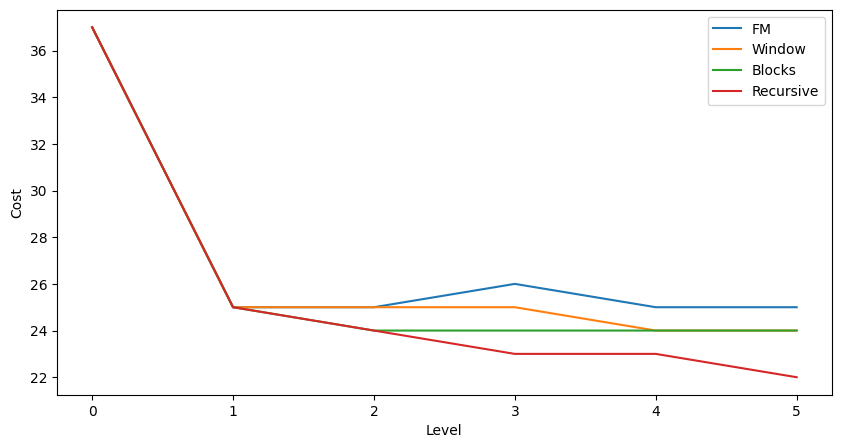

In [14]:
import matplotlib.pyplot as plt

print(cost_list)

cost_list = [initial_cost] + cost_list

index_list = [i*10 for i in range(level_limit+2)]
print(index_list)
cost_list_FM = [cost_list[i*10]for i in range(level_limit+2)]

print(cost_list_FM)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(cost_list_FM, label = 'FM')
plt.plot(cost_list_window, label = 'Window')
plt.plot(cost_list_blocks, label = 'Blocks')
plt.plot(cost_list_recursive, label = 'Recursive')

plt.legend()
plt.xlabel('Level')
plt.ylabel('Cost')

Text(0, 0.5, 'Time')

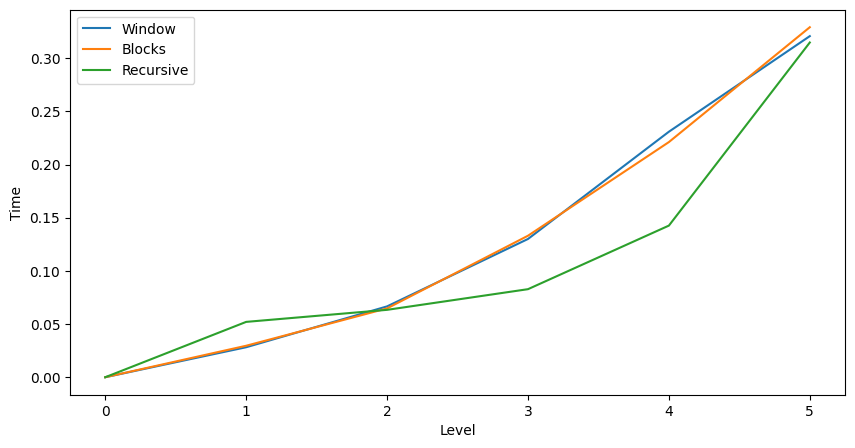

In [15]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(time_list_window, label = 'Window')
plt.plot(time_list_blocks, label = 'Blocks')
plt.plot(time_list_recursive, label = 'Recursive')

plt.legend()
plt.xlabel('Level')
plt.ylabel('Time')